# Simple table test
[![View On GitHub](https://img.shields.io/badge/View_in_Github-grey?logo=github)](https://github.com/Qrlew/docs/blob/main/tutorials/postgres_simple_table.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Qrlew/pyqrlew/blob/main/examples/postgres_simple_table.ipynb)

In this notebook, we demonstrate the application of `qrlew` to an existing database, showcasing its capability to compile SQL queries into differential privacy.

For the purpose of this demonstration, we focus on a single table, while more intricate use cases are explored in other notebooks.

## Install the database

Initially, we establish a PostgreSQL database.

This section maybe skipped if you have already access to a Postgres database.

In [1]:
%%capture
# Load the database
# Inspired by https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/postgresql.ipynb#scrollTo=YUj0878jPyz7
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql-14 graphviz
# Start postgresql server
!sudo service postgresql start
# Set password
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'pyqrlew-db'"
!sudo -u postgres psql -U postgres -c "CREATE DATABASE my_database"

We create the `census_table` table with its synthetic version `synthetic census_table`.

Note that the synthetic tables are not mandatory and can be used when `qrlew`` cannot compile into DP the query.

In [2]:
import psycopg2

connect_pars= {
    'dbname':'my_database',
    'user':'postgres',
    'port':5432,
    'password':'pyqrlew-db',
    'host':'localhost',
}
conn = psycopg2.connect(**connect_pars)

# Create a cursor
cursor = conn.cursor()

sql_script = """
CREATE SCHEMA census_schema;

CREATE TABLE census_schema.census_table (
    id SERIAL PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    age INT,
    gender VARCHAR(10),
    occupation VARCHAR(50),
    city VARCHAR(50),
    state VARCHAR(50)
);

-- Inserting sample data
INSERT INTO census_schema.census_table (first_name, last_name, age, gender, occupation, city, state)
VALUES
    ('John', 'Doe', 30, 'Male', 'Engineer', 'New York', 'NY'),
    ('Jane', 'Doe', 28, 'Female', 'Engineer', 'Los Angeles', 'CA'),
    ('Bob', 'Smith', 45, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Alice', 'Johnson', 35, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Tom', 'Brown', 50, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Emily', 'Davis', 32, 'Female', 'Software Developer', 'Seattle', 'WA'),
    ('Charlie', 'Miller', 40, 'Male', 'Accountant', 'Boston', 'MA'),
    ('Eva', 'Williams', 29, 'Female', 'Marketing Manager', 'Austin', 'TX'),
    ('Mike', 'Jones', 38, 'Male', 'Analyst', 'Denver', 'CO'),
    ('Sophia', 'Taylor', 42, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('John', 'Doe', 30, 'Male', 'Engineer', 'New York', 'NY'),
    ('Jane', 'Doe', 28, 'Female', 'Engineer', 'Los Angeles', 'CA'),
    ('Bob', 'Smith', 45, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Alice', 'Johnson', 35, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Tom', 'Brown', 50, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Emily', 'Davis', 32, 'Female', 'Software Developer', 'Seattle', 'WA'),
    ('Charlie', 'Miller', 40, 'Male', 'Accountant', 'Boston', 'MA'),
    ('Eva', 'Williams', 29, 'Female', 'Marketing Manager', 'Austin', 'TX'),
    ('Mike', 'Jones', 38, 'Male', 'Analyst', 'Denver', 'CO'),
    ('Sophia', 'Taylor', 42, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('Alex', 'Johnson', 33, 'Male', 'Analyst', 'Portland', 'OR'),
    ('Megan', 'White', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Daniel', 'Clark', 36, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Olivia', 'Martinez', 31, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('William', 'Lee', 48, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emma', 'Garcia', 29, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Ryan', 'Harris', 41, 'Male', 'Data Scientist', 'Dallas', 'TX'),
    ('Ava', 'Taylor', 26, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Christopher', 'Anderson', 37, 'Male', 'Engineer', 'Detroit', 'MI'),
    ('Sophie', 'Wilson', 34, 'Female', 'HR Specialist', 'Raleigh', 'NC'),
    ('David', 'Miller', 29, 'Male', 'Engineer', 'New York', 'NY'),
    ('Sophia', 'Taylor', 34, 'Female', 'Engineer', 'Los Angeles', 'CA'),
    ('Bob', 'Smith', 42, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Alice', 'Johnson', 39, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Tom', 'Brown', 37, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Emily', 'Davis', 28, 'Female', 'Software Developer', 'Seattle', 'WA'),
    ('Charlie', 'Miller', 45, 'Male', 'Accountant', 'Boston', 'MA'),
    ('Eva', 'Williams', 31, 'Female', 'Marketing Manager', 'Austin', 'TX'),
    ('Mike', 'Jones', 36, 'Male', 'Analyst', 'Denver', 'CO'),
    ('Sophia', 'Taylor', 49, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('Alex', 'Johnson', 37, 'Male', 'Analyst', 'Portland', 'OR'),
    ('Megan', 'White', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Daniel', 'Clark', 41, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Olivia', 'Martinez', 32, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('William', 'Lee', 47, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emma', 'Garcia', 30, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Ryan', 'Harris', 40, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Ava', 'Taylor', 26, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Christopher', 'Anderson', 35, 'Male', 'Engineer', 'Detroit', 'MI'),
    ('Sophie', 'Wilson', 33, 'Female', 'HR Specialist', 'Raleigh', 'NC'),
    ('Grace', 'Brown', 55, 'Female', 'Analyst', 'New York', 'NY'),
    ('Brian', 'Taylor', 50, 'Male', 'Professor', 'Los Angeles', 'CA'),
    ('Lily', 'Harrison', 42, 'Female', 'Engineer', 'Chicago', 'IL'),
    ('Kevin', 'Garcia', 55, 'Male', 'Analyst', 'San Francisco', 'CA'),
    ('Sophie', 'Smithson', 48, 'Female', 'Lawyer', 'Miami', 'FL'),
    ('John', 'Clarkston', 38, 'Male', 'Software Developer', 'Seattle', 'WA'),
    ('Emma', 'Millerson', 40, 'Female', 'Accountant', 'Boston', 'MA'),
    ('David', 'Williamson', 45, 'Male', 'Marketing Manager', 'Austin', 'TX'),
    ('Ava', 'Johnsonson', 38, 'Female', 'Analyst', 'Denver', 'CO'),
    ('Daniel', 'Anderson', 42, 'Male', 'Data Scientist', 'Atlanta', 'GA'),
    ('Michael', 'Martinson', 33, 'Male', 'Engineer', 'Portland', 'OR'),
    ('Sophia', 'Whiterson', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Robert', 'Davidson', 41, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Grace', 'Wilson', 45, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('Andrew', 'Leeson', 48, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emily', 'Garcia', 39, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Christopher', 'Sanders', 41, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Olivia', 'Martinez', 36, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Sophie', 'Brownson', 43, 'Female', 'Engineer', 'Detroit', 'MI'),
    ('Matthew', 'Taylors', 46, 'Male', 'HR Specialist', 'Raleigh', 'NC');

CREATE TABLE census_schema.synthetic_census_table (
    id SERIAL PRIMARY KEY,
    first_name VARCHAR(50),
    last_name VARCHAR(50),
    age INT,
    gender VARCHAR(10),
    occupation VARCHAR(50),
    city VARCHAR(50),
    state VARCHAR(50)
);

-- Inserting sample data
INSERT INTO census_schema.synthetic_census_table (first_name, last_name, age, gender, occupation, city, state)
VALUES
    ('Adam', 'Johnson', 31, 'Male', 'Engineer', 'New York', 'NY'),
    ('Sophie', 'Clark', 29, 'Female', 'Analyst', 'Los Angeles', 'CA'),
    ('David', 'Smith', 46, 'Male', 'Data Scientist', 'Chicago', 'IL'),
    ('Emma', 'Brown', 36, 'Female', 'Software Developer', 'San Francisco', 'CA'),
    ('James', 'Taylor', 51, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Olivia', 'Miller', 33, 'Female', 'Accountant', 'Seattle', 'WA'),
    ('Lucas', 'Williams', 41, 'Male', 'Marketing Manager', 'Boston', 'MA'),
    ('Ava', 'Davis', 30, 'Female', 'Analyst', 'Austin', 'TX'),
    ('Adam', 'Jones', 39, 'Male', 'Engineer', 'Denver', 'CO'),
    ('Sophie', 'Johnson', 43, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('Alex', 'Smith', 34, 'Male', 'Software Developer', 'Portland', 'OR'),
    ('Mia', 'White', 28, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Daniel', 'Clarkson', 37, 'Male', 'Lawyer', 'Houston', 'TX'),
    ('Oliver', 'Martinez', 32, 'Male', 'Data Scientist', 'Phoenix', 'AZ'),
    ('Sophia', 'Lee', 49, 'Female', 'Professor', 'Philadelphia', 'PA'),
    ('Lily', 'Garcia', 30, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Matthew', 'Harris', 42, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Emily', 'Taylor', 27, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('William', 'Anderson', 36, 'Male', 'Engineer', 'Detroit', 'MI'),
    ('Sophia', 'Wilson', 34, 'Female', 'HR Specialist', 'Raleigh', 'NC'),
    ('Ethan', 'Miller', 29, 'Male', 'Engineer', 'New York', 'NY'),
    ('Mia', 'Clark', 35, 'Female', 'Software Developer', 'Los Angeles', 'CA'),
    ('Jack', 'Smithson', 43, 'Male', 'Analyst', 'Chicago', 'IL'),
    ('Ava', 'Johnsonson', 38, 'Female', 'Data Scientist', 'San Francisco', 'CA'),
    ('Henry', 'Brown', 36, 'Male', 'Lawyer', 'Miami', 'FL'),
    ('Sophie', 'Davis', 27, 'Female', 'Accountant', 'Seattle', 'WA'),
    ('Noah', 'Williamson', 45, 'Male', 'Marketing Manager', 'Boston', 'MA'),
    ('Mia', 'Williams', 29, 'Female', 'Analyst', 'Austin', 'TX'),
    ('Ethan', 'Jones', 38, 'Male', 'Engineer', 'Denver', 'CO'),
    ('Ava', 'Taylor', 42, 'Female', 'Analyst', 'Atlanta', 'GA'),
    ('Alex', 'Johnson', 33, 'Male', 'Software Developer', 'Portland', 'OR'),
    ('Mia', 'White', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Daniel', 'Clark', 41, 'Male', 'Lawyer', 'Houston', 'TX'),
    ('Olivia', 'Martinez', 32, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('William', 'Lee', 47, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emma', 'Garcia', 30, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Ryan', 'Harris', 40, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Ava', 'Taylor', 26, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Christopher', 'Anderson', 35, 'Male', 'Engineer', 'Detroit', 'MI'),
    ('Sophie', 'Wilson', 33, 'Female', 'HR Specialist', 'Raleigh', 'NC'),
    ('Grace', 'Brown', 55, 'Female', 'Analyst', 'New York', 'NY'),
    ('Brian', 'Taylor', 50, 'Male', 'Professor', 'Los Angeles', 'CA'),
    ('Lily', 'Harrison', 42, 'Female', 'Engineer', 'Chicago', 'IL'),
    ('Kevin', 'Garcia', 55, 'Male', 'Analyst', 'San Francisco', 'CA'),
    ('Sophie', 'Smithson', 48, 'Female', 'Lawyer', 'Miami', 'FL'),
    ('John', 'Clarkston', 38, 'Male', 'Software Developer', 'Seattle', 'WA'),
    ('Emma', 'Millerson', 40, 'Female', 'Accountant', 'Boston', 'MA'),
    ('David', 'Williamson', 45, 'Male', 'Marketing Manager', 'Austin', 'TX'),
    ('Ava', 'Johnsonson', 38, 'Female', 'Analyst', 'Denver', 'CO'),
    ('Daniel', 'Anderson', 42, 'Male', 'Data Scientist', 'Atlanta', 'GA'),
    ('Michael', 'Martinson', 33, 'Male', 'Engineer', 'Portland', 'OR'),
    ('Sophia', 'Whiterson', 27, 'Female', 'Data Scientist', 'San Diego', 'CA'),
    ('Robert', 'Davidson', 41, 'Male', 'Analyst', 'Houston', 'TX'),
    ('Grace', 'Wilson', 45, 'Female', 'Data Scientist', 'Phoenix', 'AZ'),
    ('Andrew', 'Leeson', 48, 'Male', 'Professor', 'Philadelphia', 'PA'),
    ('Emily', 'Garcia', 39, 'Female', 'Data Scientist', 'Minneapolis', 'MN'),
    ('Christopher', 'Sanders', 41, 'Male', 'Entrepreneur', 'Dallas', 'TX'),
    ('Olivia', 'Martinez', 36, 'Female', 'Product Manager', 'San Jose', 'CA'),
    ('Sophie', 'Brownson', 43, 'Female', 'Engineer', 'Detroit', 'MI'),
    ('Matthew', 'Taylors', 46, 'Male', 'HR Specialist', 'Raleigh', 'NC')
"""
cursor.execute(sql_script)

# Commit the changes
conn.commit()

# Close the cursor and connection
cursor.close()
conn.close()

# Use qrlew on the database

At this stage, we have a postgres dataset that can be connected with `qrlew`.

In [3]:
%%capture
!pip install -U pyqrlew matplotlib graphviz

The `dataset_from_database` function, located in `pyqrlew.io.dataset`, enables the creation of a Dataset object from a SQLAlchemy engine.
It takes the following parameters:
- `name`: the dataset's name,
- `engine`: the SQLAlchemy engine establishing a connection to the database,
- `schema_name`: the optional name of the schema,
- `ranges`: if set to True, we use the the minimum and maximum values of numeric and datetime columns for setting their bounds.
    **This may violates differential privacy** and should be use if these values are public.
    Otherwise, use `False`. In that case, the bounds have to be provided in the SQL query,
- `possible_values_threshold`: an optional integer that serves as a threshold for identifying a column as categorical. If a column surpasses this threshold, its categories are published. Similar to the ranges parameter, exercising this option may compromise differential privacy.

In [4]:
from pyqrlew.io.dataset import dataset_from_database
from sqlalchemy import create_engine

connect_pars= {
    'dbname':'my_database',
    'user':'postgres',
    'port':5432,
    'password':'pyqrlew-db',
    'host':'localhost',
}
engine = create_engine(f'postgresql+psycopg2://{connect_pars["user"]}:{connect_pars["password"]}@{connect_pars["host"]}:{connect_pars["port"]}/{connect_pars["dbname"]}')
ds = dataset_from_database(
    name="census",
    engine=engine,
    schema_name="census_schema",
    ranges=True,
    possible_values_threshold=5
)

`qrlew` connects to the database via the SQLAlchemy engine and fetch the tables.

The table `"census_schema"."census_table"` is represented as a `Table` variant of a `Relation`.
This specific representation encapsulates all columns, their respective types, and optionally includes information about bounds and possible values.

In the provided example, we observe the bounds specification for the integer column `age` and the declaration of possible values for the string column `gender`.

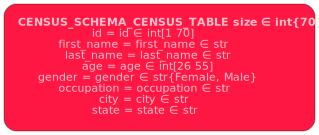

In [6]:
import graphviz
display(graphviz.Source(ds.census_schema.census_table.relation().dot()))

Any SQL query can be transformed into a `Relation`, a `qrlew` object that allow to more easily the compilation into differential privacy.

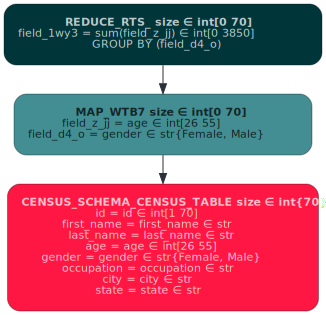

In [7]:
import pandas as pd
query = "SELECT sum(age) FROM census_schema.census_table GROUP BY gender"
relation = ds.relation(query)
display(graphviz.Source(relation.dot()))

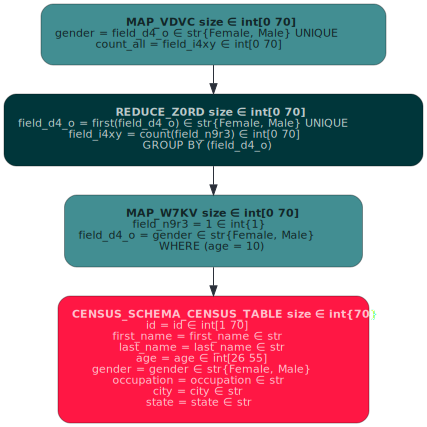

In [8]:
query = "SELECT gender as gender, COUNT(*)  AS count_all FROM census_schema.census_table WHERE age = 10 GROUP BY gender"
relation = ds.relation(query)
display(graphviz.Source(relation.dot()))

Let's convert this `Relation` into differential privacy with the `rewrite_with_differential_privacy` method that outputs:
- `privacy_unit`: the privacy unit may be defined as a column within the current table or even another table. Alternatively, each row can be protected.
- `synthetic_data`: this optional list associates each original table to its synthetic version. If these tables are provided, any queries that can't be compiled into DP will be executed on the synthetic data
- `epsilon_delta`: a dictionnary with the $\varepsilon$ and $\delta$ privacy parameters.

In [9]:
privacy_unit = [
    ("census_table", [], "_PRIVACY_UNIT_ROW_"), # each row is protected
]
synthetic_data = None

dp_relation = relation.rewrite_with_differential_privacy(
    dataset=ds,
    synthetic_data=synthetic_data,
    privacy_unit=privacy_unit,
    epsilon_delta={"epsilon": 1.0, "delta": 1e-3}
)

The result of `rewrite_with_differential_privacy` is an object that holds both the differentially private `Relation` and a `PrivateQuery` containing the invoked mechanisms during the compilation.

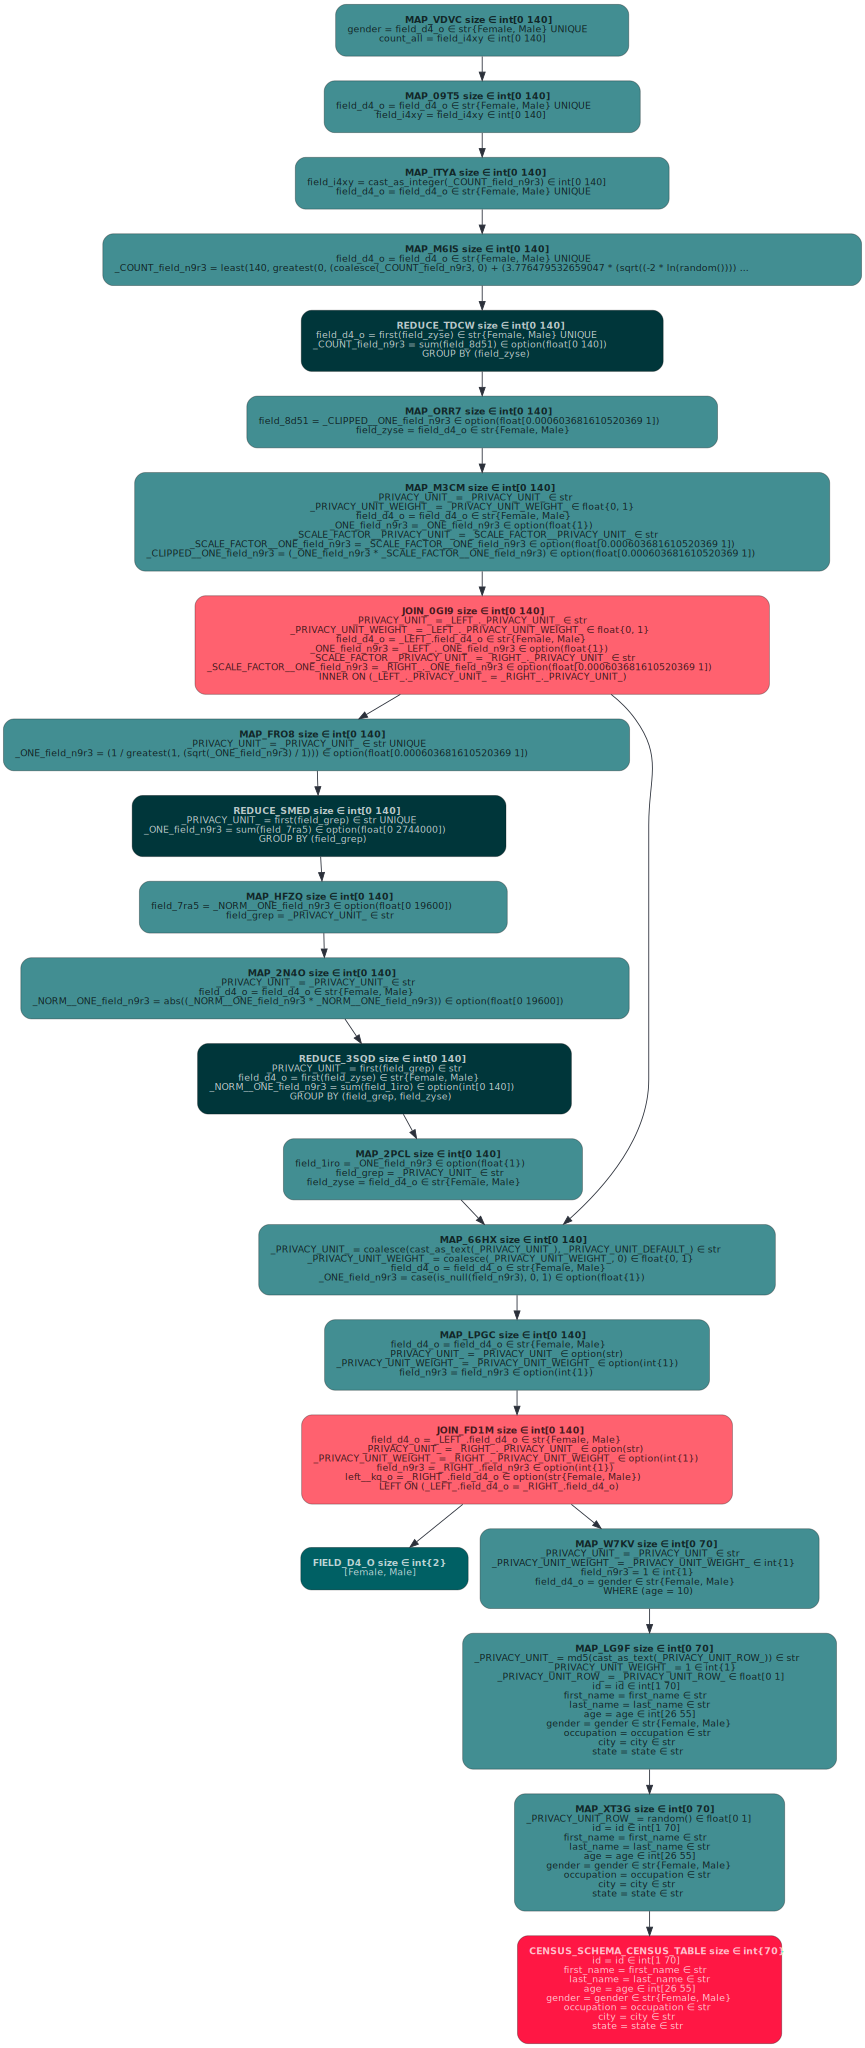

In [10]:
display(graphviz.Source(dp_relation.relation().dot()))

In this example, the only invocked mechanism is a gaussain mechanism for adding noise to the count.

In [11]:
print(dp_relation.dp_event().to_dict())

{'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 3.776479532659047, '_fields': ['module_name', 'class_name', 'noise_multiplier']}


Any `Relation` can be transformed into an SQL query:

In [12]:
dp_sql_query = dp_relation.relation().to_query()
dp_sql_query

"WITH field_d4_o (field_d4_o) AS (SELECT * FROM (VALUES ('Female'), ('Male')) AS field_d4_o (field_d4_o)), map_xt3g (_PRIVACY_UNIT_ROW_, id, first_name, last_name, age, gender, occupation, city, state) AS (SELECT RANDOM() AS _PRIVACY_UNIT_ROW_, id AS id, first_name AS first_name, last_name AS last_name, age AS age, gender AS gender, occupation AS occupation, city AS city, state AS state FROM census_schema.census_table), map_lg9f (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, _PRIVACY_UNIT_ROW_, id, first_name, last_name, age, gender, occupation, city, state) AS (SELECT MD5(CAST(_PRIVACY_UNIT_ROW_ AS TEXT)) AS _PRIVACY_UNIT_, 1 AS _PRIVACY_UNIT_WEIGHT_, _PRIVACY_UNIT_ROW_ AS _PRIVACY_UNIT_ROW_, id AS id, first_name AS first_name, last_name AS last_name, age AS age, gender AS gender, occupation AS occupation, city AS city, state AS state FROM map_xt3g), map_w7kv (_PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_, field_n9r3, field_d4_o) AS (SELECT _PRIVACY_UNIT_ AS _PRIVACY_UNIT_, _PRIVACY_UNIT_WEIGHT_ AS 

The DP query can then be sent to the database:

In [13]:
dp_results = pd.read_sql(dp_sql_query, engine)
dp_results

,gender,count_all
0,Female,1
1,Male,3


This can be compared to the result of the original query:

In [14]:
exact_results = pd.read_sql(query, engine)
exact_results

,gender,count_all


## Queries with `GROUP BY` clause

f the grouping keys are not public, we utilize the $\tau$-thresholding mechanism, which filters out keys with noisy counts below a specific threshold determined by the privacy parameters.

In [15]:
query = """
    SELECT occupation as occupation, COUNT(*) AS count_occ, AVG(age) AS avg_age
    FROM census_schema.census_table
    GROUP BY occupation
"""
relation = ds.relation(query)
privacy_unit = [
    ("census_table", [], "_PRIVACY_UNIT_ROW_"),
]
synthetic_data = None

dp_relation = relation.rewrite_with_differential_privacy(
    dataset=ds,
    synthetic_data=synthetic_data,
    privacy_unit=privacy_unit,
    epsilon_delta={"epsilon": 5.0, "delta": 5e-4}
)
print(dp_relation.dp_event().to_dict())

{'module_name': 'dp_accounting.dp_event', 'class_name': 'ComposedDpEvent', 'events': [{'module_name': 'dp_accounting.dp_event', 'class_name': 'EpsilonDeltaDpEvent', 'epsilon': 2.5, 'delta': 0.00025, '_fields': ['module_name', 'class_name', 'epsilon', 'delta']}, {'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 5.2624632808831, '_fields': ['module_name', 'class_name', 'noise_multiplier']}, {'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 5.2624632808831, '_fields': ['module_name', 'class_name', 'noise_multiplier']}, {'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 289.4354804485705, '_fields': ['module_name', 'class_name', 'noise_multiplier']}], '_fields': ['module_name', 'class_name', 'events']}


In that case, 3 gaussian mechanisms have been used for adding noise to the aggregations (1 for the count, 2 for the average) and a $(\varepsilon, \delta)$ mechanism for the $\tau$-thresholding.

If you execute the next cell multiple times, you will notice that the grouping keys may vary due to the randomness introduced by the $\tau$-thresholding mechanism.

In [16]:
dp_results = pd.read_sql(dp_relation.relation().to_query(), engine)
dp_results

,occupation,count_occ,avg_age
0,Analyst,17,74.085976
1,Engineer,21,22.989924
2,Data Scientist,19,31.201097


We can also include the grouping keys in the query's `WHERE` clause. In this case, the grouping keys are treated as public, and they all appear in the result and the $\tau$-thresholding mechnaism is not used.

In [17]:
query = """
    SELECT occupation as occupation, COUNT(*) AS count_occ, AVG(age) AS avg_age
    FROM census_schema.census_table
    WHERE occupation in ('Analyst', 'Professor')
    GROUP BY occupation
"""
relation = ds.relation(query)
privacy_unit = [
    ("census_table", [], "_PRIVACY_UNIT_ROW_"),
]
synthetic_data = None

dp_relation = relation.rewrite_with_differential_privacy(
    dataset=ds,
    synthetic_data=synthetic_data,
    privacy_unit=privacy_unit,
    epsilon_delta={"epsilon": 5.0, "delta": 5e-4}
)
print(dp_relation.dp_event().to_dict())

{'module_name': 'dp_accounting.dp_event', 'class_name': 'ComposedDpEvent', 'events': [{'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 2.5346230440950324, '_fields': ['module_name', 'class_name', 'noise_multiplier']}, {'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 2.5346230440950324, '_fields': ['module_name', 'class_name', 'noise_multiplier']}, {'module_name': 'dp_accounting.dp_event', 'class_name': 'GaussianDpEvent', 'noise_multiplier': 139.40426742522678, '_fields': ['module_name', 'class_name', 'noise_multiplier']}], '_fields': ['module_name', 'class_name', 'events']}


In [18]:
dp_results = pd.read_sql(dp_relation.relation().to_query(), engine)
dp_results

,occupation,count_occ,avg_age
0,Professor,0,38.499150
1,Analyst,18,36.381657


## Not DP-compilable queries

If the query cannot by DP-compiled by `qrlew` and no synthetic data have been provided, then `qrlew` returns an error.

In [19]:
query = """
    SELECT occupation as occupation, MAX(age) AS max_age
    FROM census_schema.census_table
    GROUP BY occupation
"""
relation = ds.relation(query)
privacy_unit = [
    ("census_table", [], "_PRIVACY_UNIT_ROW_"),
]
synthetic_data = None
try:
    dp_relation = relation.rewrite_with_differential_privacy(
        dataset=ds,
        synthetic_data=synthetic_data,
        privacy_unit=privacy_unit,
        epsilon_delta={"epsilon": 5.0, "delta": 5e-4}
    ).relation()
    dp_results = pd.read_sql(dp_relation.to_query(), engine)
    dp_results
except RuntimeError as e:
    print(f"The error is: {e}")

The error is: UnreachableProperty: differential_privacy is unreachable



If the user provides the list of the original and synthetic tables, then the query is sent to the synthetic tables and no budget has been spent.

In [20]:
query = """
    SELECT occupation as occupation, MAX(age) AS max_age
    FROM census_schema.census_table
    GROUP BY occupation
"""
relation = ds.relation(query)
privacy_unit = [("census_table", [], "_PRIVACY_UNIT_ROW_")]
synthetic_data = [
    (["census_schema", "census_table"], ["census_schema", "synthetic_census_table"])
]

dp_relation = relation.rewrite_with_differential_privacy(
    dataset=ds,
    synthetic_data=synthetic_data,
    privacy_unit=privacy_unit,
    epsilon_delta={"epsilon": 5.0, "delta": 5e-4}
)
print(dp_relation.dp_event().to_dict())

{'module_name': 'dp_accounting.dp_event', 'class_name': 'NoOpDpEvent', '_fields': ['module_name', 'class_name']}
